# 스트리밍 방법 (How to stream)

!!! info "필수 조건 (Prerequisites)"

    이 가이드에서는 다음 사항에 대한 지식이 있다고 가정합니다.
    
    - [스트리밍 (Streaming)](../../concepts/streaming/)
    - [채팅 모델 (Chat Models)](https://python.langchain.com/docs/concepts/chat_models/)

스트리밍 (Streaming)은 LLM을 기반으로 구축된 애플리케이션의 반응성을 향상시키는 데 매우 중요합니다. 완전한 응답이 준비되기 전에도 출력을 점진적으로 표시함으로써 스트리밍은 특히 LLM의 대기 시간 (latency)을 처리할 때 사용자 경험 (UX)을 크게 향상시킵니다.

LangGraph는 스트리밍을 기본적으로 지원하도록 구축되었습니다. 그래프 실행 (graph run)에서 출력을 스트리밍하는 방법에는 여러 가지가 있습니다.

- `"values"`: 각 단계 후 상태 (state)의 모든 값을 내보냅니다.
- `"updates"`: 각 단계 후 노드 이름과 노드에서 반환된 업데이트만 내보냅니다. 동일한 단계에서 여러 업데이트가 수행되는 경우 (예: 여러 노드가 실행되는 경우) 이러한 업데이트는 개별적으로 내보내집니다.
- `"custom"`: `StreamWriter`를 사용하여 노드 내부에서 사용자 정의 데이터 (custom data)를 내보냅니다.
- [`"messages"`](../streaming-tokens): 노드 내부의 LLM 호출에 대한 메타데이터 (metadata)와 함께 LLM 메시지를 토큰 (token) 단위로 내보냅니다.
- `"debug"`: 각 단계에 대한 가능한 많은 정보와 함께 디버그 이벤트 (debug events)를 내보냅니다.

`graph.stream(..., stream_mode=<stream_mode>)` 메서드를 사용하여 그래프에서 출력을 스트리밍할 수 있습니다 (예:)

=== "동기 (Sync)"

    ```python
    for chunk in graph.stream(inputs, stream_mode="updates"):
        print(chunk)
    ```

=== "비동기 (Async)"

    ```python
    async for chunk in graph.astream(inputs, stream_mode="updates"):
        print(chunk)
    ```

`stream_mode` 매개변수에 목록을 제공하여 여러 스트리밍 모드 (streaming mode)를 결합할 수도 있습니다.

=== "동기 (Sync)"

    ```python
    for chunk in graph.stream(inputs, stream_mode=["updates", "custom"]):
        print(chunk)
    ```

=== "비동기 (Async)"

    ```python
    async for chunk in graph.astream(inputs, stream_mode=["updates", "custom"]):
        print(chunk)
    ```

## Setup

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

In [1]:
# import getpass
# import os


# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("OPENAI_API_KEY")

In [2]:
from dotenv import load_dotenv

load_dotenv()



True

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

Let's define a simple graph with two nodes:

## 그래프 정의 (Define graph)

In [3]:
from typing import TypedDict
from langgraph.graph import StateGraph, START


class State(TypedDict):
    topic: str
    joke: str


def refine_topic(state: State):
    return {"topic": state["topic"] + " and cats"}


def generate_joke(state: State):
    return {"joke": f"This is a joke about {state['topic']}"}


graph = (
    StateGraph(State)
    .add_node(refine_topic)
    .add_node(generate_joke)
    .add_edge(START, "refine_topic")
    .add_edge("refine_topic", "generate_joke")
    .compile()
)

## 상태의 모든 값 스트리밍 (stream_mode="values") {#values}

이것은 각 단계 이후에 상태(state)의 **모든 값**을 스트리밍하는 데 사용됩니다.

In [4]:
for chunk in graph.stream(
    {"topic": "ice cream"},
    # highlight-next-line
    stream_mode="values",
):
    print(chunk)

{'topic': 'ice cream'}
{'topic': 'ice cream and cats'}
{'topic': 'ice cream and cats', 'joke': 'This is a joke about ice cream and cats'}


## 노드에서 상태 업데이트 스트리밍 (stream_mode="updates") {#updates}

이것은 각 단계 이후에 노드에서 반환된 **상태 업데이트**(state updates)만 스트리밍하는 데 사용됩니다. 스트리밍된 출력에는 노드의 이름과 업데이트가 포함됩니다.

In [7]:
result = graph.stream(
    {"topic": "ice cream"},
    # highlight-next-line
    stream_mode="updates",
)

In [9]:
result = list(result)

In [10]:
result

[{'refine_topic': {'topic': 'ice cream and cats'}},
 {'generate_joke': {'joke': 'This is a joke about ice cream and cats'}}]

In [11]:
for chunk in graph.stream(
    {"topic": "ice cream"},
    # highlight-next-line
    stream_mode="updates",
):
    print(chunk)

{'refine_topic': {'topic': 'ice cream and cats'}}
{'generate_joke': {'joke': 'This is a joke about ice cream and cats'}}


## 디버그 이벤트 스트리밍 (stream_mode="debug") {#debug}

이것은 각 단계에 대한 가능한 많은 정보를 포함하는 **디버그 이벤트**(debug events)를 스트리밍하는 데 사용됩니다. 여기에는 실행되도록 예약된 작업과 작업 실행 결과에 대한 정보가 포함됩니다.

In [12]:
for chunk in graph.stream(
    {"topic": "ice cream"},
    # highlight-next-line
    stream_mode="debug",
):
    print(chunk)

{'type': 'task', 'timestamp': '2025-02-19T07:32:23.809086+00:00', 'step': 1, 'payload': {'id': 'ab2b4f59-1b89-4aa0-412c-7923e99ac8ff', 'name': 'refine_topic', 'input': {'topic': 'ice cream'}, 'triggers': ['start:refine_topic']}}
{'type': 'task_result', 'timestamp': '2025-02-19T07:32:23.810077+00:00', 'step': 1, 'payload': {'id': 'ab2b4f59-1b89-4aa0-412c-7923e99ac8ff', 'name': 'refine_topic', 'error': None, 'result': [('topic', 'ice cream and cats')], 'interrupts': []}}
{'type': 'task', 'timestamp': '2025-02-19T07:32:23.810226+00:00', 'step': 2, 'payload': {'id': '6a91ea6a-d985-1f90-a92e-97cfdc061816', 'name': 'generate_joke', 'input': {'topic': 'ice cream and cats'}, 'triggers': ['refine_topic']}}
{'type': 'task_result', 'timestamp': '2025-02-19T07:32:23.810850+00:00', 'step': 2, 'payload': {'id': '6a91ea6a-d985-1f90-a92e-97cfdc061816', 'name': 'generate_joke', 'error': None, 'result': [('joke', 'This is a joke about ice cream and cats')], 'interrupts': []}}


## LLM 토큰 스트리밍 ([stream_mode="messages"](../streaming-tokens)) {#messages}

이를 통해 노드(nodes) 또는 작업(tasks) 내부의 모든 LLM 호출에 대한 메타데이터(metadata)와 함께 **LLM 메시지(messages)를 토큰 단위(token-by-token)**로 스트리밍할 수 있습니다. 위의 예제를 수정하여 LLM 호출을 포함해 보겠습니다.

In [14]:
# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

# llm = ChatOpenAI(model="gpt-4o-mini")
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")


def generate_joke(state: State):
    # highlight-next-line
    llm_response = llm.invoke(
        # highlight-next-line
        [
            # highlight-next-line
            {"role": "user", "content": f"Generate a joke about {state['topic']}"}
            # highlight-next-line
        ]
        # highlight-next-line
    )
    return {"joke": llm_response.content}


graph = (
    StateGraph(State)
    .add_node(refine_topic)
    .add_node(generate_joke)
    .add_edge(START, "refine_topic")
    .add_edge("refine_topic", "generate_joke")
    .compile()
)

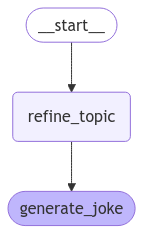

In [15]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [17]:
for message_chunk, metadata in graph.stream(
    {"topic": "ice cream"},
    # highlight-next-line
    stream_mode="messages",
):
    if message_chunk.content:
        print(message_chunk.content, end="|", flush=True)

Why| did the cat| refuse the ice cream? 

Because it was purr-izzo! |

In [18]:
metadata

{'langgraph_step': 2,
 'langgraph_node': 'generate_joke',
 'langgraph_triggers': ['refine_topic'],
 'langgraph_path': ('__pregel_pull', 'generate_joke'),
 'langgraph_checkpoint_ns': 'generate_joke:29363ed3-d4a3-469d-7514-97e45a79c7e4',
 'checkpoint_ns': 'generate_joke:29363ed3-d4a3-469d-7514-97e45a79c7e4',
 'ls_provider': 'google_genai',
 'ls_model_name': 'models/gemini-2.0-flash-001',
 'ls_model_type': 'chat',
 'ls_temperature': 0.7}

## 사용자 정의 데이터 스트리밍 (stream_mode="custom") {#custom}

노드 내부에서 [`StreamWriter`][langgraph.types.StreamWriter]를 사용하여 사용자 정의 데이터(custom data)를 스트리밍하려면 다음을 사용하세요.

In [25]:
from langgraph.types import StreamWriter


# highlight-next-line
def generate_joke(state: State, writer: StreamWriter):
    # highlight-next-line
    writer({"custom_key": "Writing custom data while generating a joke"})
    return {"joke": f"This is a joke about {state['topic']}"}


graph = (
    StateGraph(State)
    .add_node(refine_topic)
    .add_node(generate_joke)
    .add_edge(START, "refine_topic")
    .add_edge("refine_topic", "generate_joke")
    .compile()
)

In [26]:
for chunk in graph.stream(
    {"topic": "ice cream"},
    # highlight-next-line
    stream_mode="custom",
):
    print(chunk)

{'custom_key': 'Writing custom data while generating a joke'}


## 여러 스트리밍 모드 구성 (Configure multiple streaming modes) {#multiple}

여러 스트리밍 모드를 결합하려면 이 기능을 사용하세요. 출력은 튜플 `(stream_mode, streamed_output)` 형태로 스트리밍됩니다.

In [38]:
for stream_mode, chunk in graph.stream(
    {"topic": "ice cream"},
    # highlight-next-line
    stream_mode=["updates", "custom"],
):
    print(f"Stream mode: {stream_mode}")
    print(chunk)
    print("\n")

Stream mode: updates
{'refine_topic': {'topic': 'ice cream and cats'}}


Stream mode: custom
{'custom_key': 'Writing custom data while generating a joke'}


Stream mode: updates
{'generate_joke': {'joke': 'This is a joke about ice cream and cats'}}


